## Data analysis

In [1]:
#from utils import *
from lin_GAN_penny_script import *
import torch
import numpy as np
import pandas as pd
from scipy.stats import f
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

2023-01-30 17:07:49.436133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-30 17:07:49.436179: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-30 17:07:51.280018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-30 17:07:51.280055: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-30 17:07:51.280067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-bozzololu): /proc/driver/nvidia/version does not exist
2023-01-30 17:07:51.280238: I tensorflow/core/platform/cpu_featu

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
# dataloader = torch.utils.data.DataLoader(rd, batch_size=1, shuffle=True, drop_last=True)

# for elem in dataloader:
#     plt.imshow(elem[0][0])

In [4]:
#show_images(GAN_imgs[0], 20)

In [5]:
#show_images(QGAN_imgs[100:150], 20)

In [6]:
# Plotting histogram probability distributions 

# linear_gan_synthetic = np.concatenate(GAN_imgs).reshape(len(GAN_imgs), 8, 8)
# reshaped_linear_gan_synthetic = linear_gan_synthetic.reshape(len(GAN_imgs)*64)
# linear_qgan_synthetic = np.concatenate(QGAN_imgs).reshape(len(QGAN_imgs), 8, 8)
# reshaped_linear_qgan_synthetic = linear_qgan_synthetic.reshape(len(QGAN_imgs)*64)
# real_data = np.concatenate(real_img).reshape(len(real_img), 8, 8)
# reshaped_real_data = real_data.reshape(len(real_data)*64)

# empty_dataframe = pd.DataFrame(columns=['Real data','GAN', 'QGAN'])
# df1 = pd.DataFrame(reshaped_real_data)
# df2 = pd.DataFrame(reshaped_linear_gan_synthetic)
# df3 = pd.DataFrame(reshaped_linear_qgan_synthetic)
# df = pd.concat([df1, df2, df3], 1)
# df.columns = ['Real data','GAN', 'QGAN']

# sns.displot(data = df, kind = 'kde')

In [7]:
def show_images(data, n_samples):

    plt.figure(figsize=(8,2))

    for i in range(n_samples):
        image = data[i][0]#.reshape(8, 8)
        plt.subplot(1,n_samples,i+1)
        plt.axis('off')
        plt.imshow(image.numpy(), cmap='gray')
        
    plt.show()


def split_train_test(real_data, idx, num_classes):

    train_data, test_data = [], []

    for i, (img, label) in enumerate(real_data):

        if i < idx:

            # one hot enoding for training labels
            lab = torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes)
            #print('img shape train data: ', img.shape)
            train_data.append((img, lab))
        
        else:

            test_data.append((img, label))

    return train_data, test_data


def build_dataset(model_type, noise_dim, path, len_real_data, labels, num_classes, max_epoch):

    if model_type == 'Classical_linear':

        GAN_imgs, dataset, idx = [], [], 0      

         # r=root, d=directories, f = files
        for r, d, f in os.walk(path):                      
            for file in f:                 
                if file.endswith(f"lin_gen_epoch_{max_epoch}"):               
                
                    model = torch.load(os.path.join(r, file))

                    for k in range(len_real_data):      
                
                        image = model(torch.rand(1, noise_dim)).view(8,8).cpu().detach()
                        #print('img shape: ', image.shape)
                        GAN_imgs.append(image)
                        label = torch.nn.functional.one_hot(torch.tensor(labels[idx]), num_classes=num_classes)
                        dataset.append((image, label))
                        
                    idx += 1
                   

    elif model_type == 'Quantum_linear':

        GAN_imgs, dataset, idx = [], [], 0  
    
        for r, d, f in os.walk(path):               
            for file in f:                     
                if file.endswith(f"lin_q_gen_epoch_{max_epoch}"):  

                    model = torch.load(os.path.join(r, file))                   

                    for k in range(len_real_data):   

                        image = model(torch.rand(1, noise_dim)).view(8,8).cpu().detach()
                      
                        GAN_imgs.append(image.shape)
                        label = torch.nn.functional.one_hot(torch.tensor(labels[idx]), num_classes=num_classes)
                        dataset.append((image, label))
                        
                    idx += 1
    
    else:

        print('Network typology not admitted.')

    return GAN_imgs, dataset


class Classificator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding = 'same')
        #self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(576, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        #print(x.shape)
        x = torch.flatten(x,1) # flatten all dimensions except batch
        #print(x.shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)


def training_classification(classificator, train_dataloader, epochs, learning_rate, batch_size, path):

    optimizer = torch.optim.SGD(classificator.parameters(),lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    episode_loss = []
    tot_loss_mean = []

    with tqdm(range(epochs)) as tepochs:

        for epoch in tepochs:  

            running_loss = 0.0
            for i, data in enumerate(train_dataloader):

                #(train, label) = data
                #print(data[0].shape)
                #print(data[1].shape)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = classificator(data[0].view(batch_size,1,8,8))#(data[0].size(0), -1))
                #print('Outputs training: ', outputs.shape)

                label = data[1].float()

                #print('Label: ', label.shape)

                loss = loss_fn(outputs, label)
                #print(loss)
                loss.backward()
                optimizer.step()

                episode_loss.append(loss.item())

                # print statistics
                running_loss += loss.item()
                
                tepochs.set_postfix({'Classificator loss' : loss.item()})
            
            tot_loss_mean.append(np.mean(episode_loss))

            torch.save(classificator.state_dict(), path + 'classificator.pt')

    return tot_loss_mean            



def evaluate_accuracy(classificator, test_dataloader, batch_size, path):

    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_dataloader:
            
            labels = data[1]
            #print('labels: ', labels)

            #print('Data:', data[0].shape)

            classificator.load_state_dict(torch.load(path + 'classificator.pt'))
            
            outputs = classificator(data[0].view(batch_size,1,8,8))#.view(data.size(0), -1)
            #print('Output accuracy: ', outputs.shape)

            _, predicted = torch.max(outputs.data, 1)
            #print('pred: ', predicted)

            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()
            #print('correct', correct)

    #print('total', total)

    #print(f'Accuracy on the {total} test images: {100 * correct / total} %')

    return 100 * correct / total



def training_run(model_type, classificator, dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True):

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if model_type == 'Classical_linear':
        
        save_path = 'torch_results/Classificator/GAN_data/' + current_time + '/'

    elif model_type == 'Quantum_linear':

        save_path = 'torch_results/Classificator/QGAN_data/' + current_time + '/'
    
    else:
        print('Model typology not admitted.')
    summary_writer = tf.summary.create_file_writer(save_path)

    loss_synthetic = training_classification(classificator, dataloader, epochs, learning_rate, batch_size, save_path)
    acc_synthetic = evaluate_accuracy(classificator, real_dataloader, batch_size, save_path)

    if reset_parameters:
        for layer in classificator.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
    
    return acc_synthetic, loss_synthetic


def multiple_runs(runs, model_type, c_classificator, q_classificator, synthetic_dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True):

    acc_tot = []
    q_acc_tot = []
    loss_tot = []
    q_loss_tot = []

    for run in range(runs):

        print(f'---------------------------------------- RUN {run+1} ----------------------------------------')
        
        print('Classical GAN training: ')
        classical_accuracy, classical_loss = training_run(model_type[0], c_classificator, synthetic_dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True)
        #print(classical_accuracy)

        print('Quantum GAN training: ')
        quantum_accuracy, quantum_loss = training_run(model_type[1], q_classificator, synthetic_dataloader, real_dataloader, learning_rate, epochs, batch_size, reset_parameters=True)

        acc_tot.append(classical_accuracy)
        q_acc_tot.append(quantum_accuracy)
        loss_tot.append(classical_loss)
        q_loss_tot.append(quantum_loss)

    c_acc_mean = np.mean(acc_tot)
    c_acc_std = np.std(acc_tot)
    q_acc_mean = np.mean(q_acc_tot)    
    q_acc_std = np.std(q_acc_tot)

    c_loss_mean = np.mean(loss_tot)
    c_loss_std = np.std(loss_tot)
    q_loss_mean = np.mean(q_loss_tot)    
    q_loss_std = np.std(q_loss_tot)

    delta_acc = [np.abs(acc_tot[i]-q_acc_tot[i]) for i in range(len(acc_tot))]

    dict = {'GAN_data_accuracy': [acc_tot], 'QGAN_data_accuracy': [q_acc_tot]}  
       
    df = pd.DataFrame(dict)         
    # saving the dataframe 
    df.to_csv(f'torch_results/Metrics/Classification_accuracies_{3}_labels.csv')

    return acc_tot, q_acc_tot, delta_acc, c_loss_mean, q_loss_mean#, c_acc_mean, c_acc_std, q_acc_mean, q_acc_std, c_loss_std, , q_loss_std

In [8]:
# img = GAN_imgs_0[0].view(GAN_imgs_0[0].size(0), -1)
# img.shape

In [9]:
# img = GAN_imgs[0].view(1,1,8,8)#(GAN_imgs_0[0].size(0), -1)

# input = torch.rand(1,64)

# classificator = Classificator(1)#QGAN_imgs[0].shape[1])
# classificator(img), img.shape

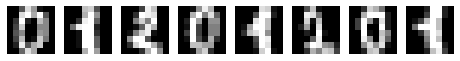

(1797, 537, 429, 108)

In [10]:
noise_dim = 5
image_size = 8
model_type = ['Classical_linear', 'Quantum_linear']
labels = [0,1,2]
num_classes = len(labels)
runs = 10
epochs = 50
batch_size = 4
learning_rate = 0.01
#num_classes = 2

# Showing real data
digits, targets = datasets.load_digits(return_X_y =True)
digits = digits.reshape(len(digits), 8, 8)

# Selecting only specific labels
real_data, real_img = resize_data(digits, targets, label = (0,1,2), image_size = image_size)

# Splitting train-test data (one-hot encoding included)
idx = int(len(real_data)*0.8)
train_data, test_data = split_train_test(real_data, idx, num_classes=num_classes)
show_images(real_data, 8)
len(digits), len(real_data), len(train_data), len(test_data)

In [11]:
#-------------------------------------------------------- Making inference --------------------------------------------------------
len_real_data = len(real_data)

# Bulding synthetic classical dataset (one-hot encoding included)
path = "torch_results/GAN/GAN_linear"
GAN_imgs, synthetic_classical_data = build_dataset(model_type[0], noise_dim, path, len_real_data, labels, num_classes, max_epoch=2)

# Bulding synthetic quantum dataset (one-hot encoding included)
q_path = "torch_results/QGAN/QGAN_linear"
QGAN_imgs, synthetic_quantum_data = build_dataset(model_type[1], noise_dim, q_path, len_real_data, labels, num_classes, max_epoch=2)

In [12]:
len(synthetic_classical_data), len(synthetic_quantum_data)#, synthetic_classical_data[0][1]

(1611, 1611, tensor([1, 0, 0]))

In [13]:
real_dataloader = DataLoader(real_data, batch_size=batch_size, shuffle=True, drop_last=True)
synthetic_dataloader = DataLoader(synthetic_classical_data, batch_size=batch_size, shuffle=True, drop_last=True)
q_synthetic_dataloader = DataLoader(synthetic_quantum_data, batch_size=batch_size, shuffle=True, drop_last=True)

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle=True, drop_last=True)

In [14]:
################################## Real data ##################################

# r_classificator_path = 'torch_results/Classificator/Real_data/' + current_time + '/'
# summary_writer = tf.summary.create_file_writer(r_classificator_path)
# r_classificator = Classificator(num_classes)

# learning_rate = 0.01
# classical_loss_real = training_classification(r_classificator, train_dataloader, epochs, learning_rate, batch_size, r_classificator_path)
# acc_real = evaluate_accuracy(r_classificator, test_dataloader, batch_size, r_classificator_path)
# acc_real

In [15]:
c_classificator = Classificator(num_classes)
q_classificator = Classificator(num_classes)

acc_tot, q_acc_tot, delta_acc, c_loss, q_loss = multiple_runs(runs, model_type, c_classificator, q_classificator, synthetic_dataloader, real_dataloader, learning_rate, 
                                                              epochs, batch_size, reset_parameters=True) 

---------------------------------------- RUN 1 ----------------------------------------
Classical GAN training: 


100%|██████████| 50/50 [01:20<00:00,  1.61s/it, Classificator loss=0.551]


Quantum GAN training: 


100%|██████████| 50/50 [01:32<00:00,  1.84s/it, Classificator loss=0.551]


---------------------------------------- RUN 2 ----------------------------------------
Classical GAN training: 


100%|██████████| 50/50 [01:29<00:00,  1.79s/it, Classificator loss=0.551]


Quantum GAN training: 


100%|██████████| 50/50 [01:36<00:00,  1.93s/it, Classificator loss=0.551]


---------------------------------------- RUN 3 ----------------------------------------
Classical GAN training: 


100%|██████████| 50/50 [01:30<00:00,  1.81s/it, Classificator loss=0.552]


Quantum GAN training: 


100%|██████████| 50/50 [01:36<00:00,  1.93s/it, Classificator loss=0.551]


---------------------------------------- RUN 4 ----------------------------------------
Classical GAN training: 


100%|██████████| 50/50 [01:32<00:00,  1.86s/it, Classificator loss=0.551]


Quantum GAN training: 


100%|██████████| 50/50 [01:31<00:00,  1.83s/it, Classificator loss=0.551]


---------------------------------------- RUN 5 ----------------------------------------
Classical GAN training: 


100%|██████████| 50/50 [01:37<00:00,  1.94s/it, Classificator loss=0.551]


Quantum GAN training: 


100%|██████████| 50/50 [01:36<00:00,  1.93s/it, Classificator loss=0.784]


---------------------------------------- RUN 6 ----------------------------------------
Classical GAN training: 


100%|██████████| 50/50 [01:35<00:00,  1.90s/it, Classificator loss=0.551]


Quantum GAN training: 


100%|██████████| 50/50 [01:47<00:00,  2.15s/it, Classificator loss=0.551]


---------------------------------------- RUN 7 ----------------------------------------
Classical GAN training: 


100%|██████████| 50/50 [01:46<00:00,  2.13s/it, Classificator loss=0.551]


Quantum GAN training: 


100%|██████████| 50/50 [02:02<00:00,  2.45s/it, Classificator loss=0.551]


---------------------------------------- RUN 8 ----------------------------------------
Classical GAN training: 


100%|██████████| 50/50 [01:50<00:00,  2.21s/it, Classificator loss=0.551]


Quantum GAN training: 


100%|██████████| 50/50 [01:50<00:00,  2.22s/it, Classificator loss=0.552]


---------------------------------------- RUN 9 ----------------------------------------
Classical GAN training: 


100%|██████████| 50/50 [01:54<00:00,  2.29s/it, Classificator loss=0.551]


Quantum GAN training: 


100%|██████████| 50/50 [01:50<00:00,  2.20s/it, Classificator loss=0.552]


---------------------------------------- RUN 10 ----------------------------------------
Classical GAN training: 


100%|██████████| 50/50 [01:46<00:00,  2.14s/it, Classificator loss=0.551]


Quantum GAN training: 


100%|██████████| 50/50 [01:41<00:00,  2.04s/it, Classificator loss=0.551]


In [16]:
acc_final = []
loss_final = []
q_acc_final = []
q_loss_final = []

acc_final.append(acc_tot)
q_acc_final.append(q_acc_tot)
#acc_final, q_acc_final#, delta_acc

In [17]:
def accuracy_boxplot(acc_tot, q_acc_tot, labels, num_tests):

    fig, ax = plt.subplots(figsize=(12, 6), facecolor='oldlace')

    for i in range(num_tests):
    
        boxes = ax.boxplot(acc_tot[i], patch_artist=True, showmeans = False, showfliers=False, widths = 0.42, labels = labels)
        for box in boxes["boxes"]:
            box.set(facecolor = "green")

        q_boxes = ax.boxplot(q_acc_tot[i], patch_artist=True, showmeans = False, showfliers=False, widths = 0.32, labels = labels)
        for box in q_boxes["boxes"]:
            box.set(facecolor = "palegreen")

        fig.text(0.92, 0.73, f'GAN linear\nGen: 204 params\nDisc: 5127 params', backgroundcolor='green', color='black', weight='roman')
        fig.text(0.92, 0.63, f'QGAN linear\nGen: 120 params\nDisc: 5127 params', backgroundcolor='palegreen', color='black', weight='roman')
        #fig.text(0.92, 0.52, f'QGAN linear\nGen: 120 params\nDisc: 5127 params', backgroundcolor='darkkhaki', color='black', weight='roman')
        #fig.text(0.92, 0.52, f'QGAN linear\nGen: 120 params\nDisc: 5127 params', backgroundcolor='palegoldenrod', color='black', weight='roman')

        ax.set_xlabel('Number of digits labels', fontsize=16)
        ax.set_ylabel('Accuracy score', fontsize=16)
        plt.grid()
        plt.title(f"Accuracy classification score - Handwritten 8x8 dataset", fontsize=18)
        plt.savefig(f'torch_results//Metrics/Classification_accuracies_{3}_labels.png')
        plt.show()

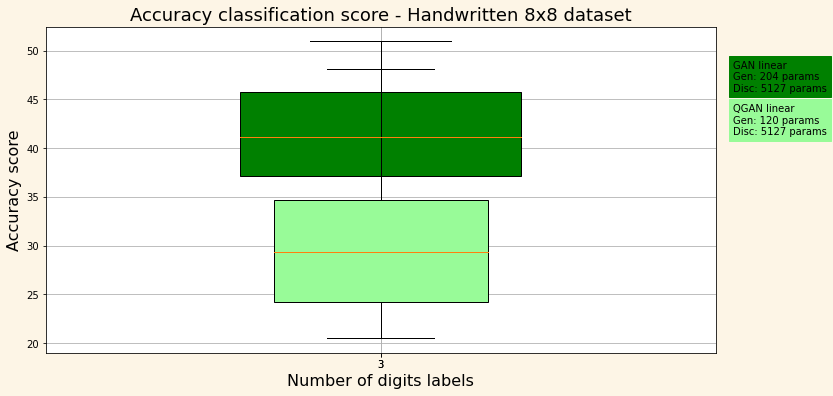

In [18]:
labels = [3]
boxplot = accuracy_boxplot(acc_final, q_acc_final, labels, 1)
boxplot

In [ ]:
# dict = {'Real_data_acc': [acc_real], 'GAN_data_acc': [acc_synthetic], 'QGAN_data_acc': [acc_q_synthetic]}  
       
# df = pd.DataFrame(dict) 
    
# # saving the dataframe 
# df.to_csv(f'torch_results/Metrics/Classification_accuracies_{len(labels)}_labels.csv')


# data = {'GAN 204 params':acc_synthetic, 'QGAN 120 params':acc_q_synthetic}
# courses = list(data.keys())
# values = list(data.values())

# label1 = [np.round(acc_synthetic, 3)]
# label2 = [np.round(acc_q_synthetic, 3)]
  
# fig = plt.figure(figsize = (13, 9))
 
# # creating the bar plot
# plt.bar(courses, values, color = ['blue', 'red'], data = [acc_synthetic, acc_q_synthetic])
# plt.text(x = -0.06 , y = data['GAN 204 params'] + 0.5, s = label1[0], size = 15)
# plt.text(x = 0.94 , y = data['QGAN 120 params'] + 0.6, s = label2[0], size = 15) 
# plt.ylabel("Accuracy", fontsize=18)
# plt.title(f"Accuracy classification score - Handwritten 8x8 dataset - {len(labels)} labels", fontsize=18)
# plt.savefig(f'torch_results//Metrics/Classification_accuracies_{len(labels)}_labels.png')
# plt.show()


# plt.figure(figsize=(10, 7))
# #plt.plot(np.arange(epochs), classical_loss_real[:epochs], label = 'Train: real data\nTest:real data')
# plt.plot(np.arange(epochs), classical_loss_synthetic[:epochs], label = 'Train: synthetic classical data\nTest: real data')
# plt.plot(np.arange(epochs), quantum_loss_synthetic[:epochs], label = 'Train: synthetic quantum data\nTest: real data')
# plt.title(f'Classification training loss - {len(labels)} labels')
# plt.legend()
# plt.savefig(f'torch_results//Metrics/Classification_loss_{len(labels)}_labels.png')
# plt.show()
